In [ ]:
# Cell 1: Imports and Configurations

import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torchio as tio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict


# Set seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Global configs
IMG_SIZE = 128
BATCH_SIZE = 2
NUM_CLASSES = 4


✅ Using device: cuda


In [16]:

class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.patient_dirs = sorted(os.listdir(root_dir))
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_id = self.patient_dirs[idx]
        patient_path = os.path.join(self.root_dir, patient_id)
        available_files = os.listdir(patient_path)
        image_data = []

        modality_map = {
            "flair": f"{patient_id}_flair.nii",
            "t1": f"{patient_id}_t1.nii",
            "t1ce": f"{patient_id}_t1ce.nii",
            "t2": f"{patient_id}_t2.nii",
        }

        for key, file in modality_map.items():
            img = nib.load(os.path.join(patient_path, file)).get_fdata()
            image_data.append(img)

        image_np = np.stack(image_data, axis=0).astype(np.float32)
        image_tensor = torch.tensor(image_np)

        for f in available_files:
            if 'seg' in f.lower():
                label_np = nib.load(os.path.join(patient_path, f)).get_fdata().astype(np.uint8)
                label_np[label_np == 4] = 3
                label_tensor = torch.from_numpy(label_np).long().unsqueeze(0)
                break

        if self.transform:
            subject = tio.Subject(
                images=tio.ScalarImage(tensor=image_tensor),
                label=tio.LabelMap(tensor=label_tensor)
            )
            subject = self.transform(subject)
            image_tensor = subject['images'].data
            label_tensor = subject['label'].data

        return image_tensor, label_tensor, patient_id


In [17]:
# Cell 3: Preprocessing Transforms

preprocess = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((128, 128, 128)),
    tio.ZNormalization()
])

augment = tio.Compose([
    tio.RandomBiasField(p=0.3),
    tio.RandomGamma(p=0.3),
    tio.RandomNoise(p=0.2),
    tio.RandomFlip(axes=('LR',), p=0.5),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5, p=0.5),
    preprocess
])


In [26]:
# Cell 4: Hospital Loader Setup

# Hospital1_Train = 'Data/2023GLI/TrainingData'
# Hospital1_Val   = 'Data/2023GLI/ValidationData'
# Hospital2_Train = 'Data/2023MEN/TrainingData'
# Hospital2_Val   = 'Data/2023MEN/ValidationData'
# Hospital3_Train = 'Data/2023MET/TrainingData'
# Hospital3_Val   = 'Data/2023MET/ValidationData'
# Hospital4_Train = 'Data/2023PED/TrainingData'
# Hospital4_Val   = 'Data/2023PED/ValidationData'
# Hospital5_Train = 'Data/2023SSA/TrainingData'
# Hospital5_Val   = 'Data/2023SSA/ValidationData'
# Hospital6_Train_Val = 'Data/BraTS2021'
# Hospital7_Train = 'Data/BraTS2020/TrainingData'
# Hospital7_Val   = 'Data/BraTS2020/ValidationData'
# Hospital8_Train_Val = 'Data/BraTS2019/HGG'
# Hospital9_Train_Val = 'Data/BraTS2019/LGG'



hospital_paths = {
    # "Hospital1": "Data/BraTS2019/LGG",
    # "Hospital2": "Data/BraTS2019/HGG",
    "Hospital3": "Data/BraTS2020/TrainingData",
    "Hospital4": "Data/BraTS2021",
    # "Hospital5": "Data/2023SSA/TrainingData",
}

hospital_loaders = {}
for name, path in hospital_paths.items():
    dataset = BraTSDataset(path, transform=preprocess)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    hospital_loaders[name] = {
        "train": DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True),
        "val": DataLoader(val_set, batch_size=1, shuffle=False)
    }

print("✅ Hospital loaders ready.")


✅ Hospital loaders ready.


In [27]:
# Cell 5: TumorVisNet3D Architecture

class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False, p=0.2):
        super().__init__()
        layers = [
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout3d(p))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class ViTBottleneck3D(nn.Module):
    def __init__(self, input_dim, embed_dim=256, num_heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.proj = nn.Conv3d(input_dim, embed_dim, kernel_size=1)
        self.reproj = nn.Conv3d(embed_dim, input_dim, kernel_size=1)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, x):
        B, C, D, H, W = x.shape
        x = self.proj(x)                       # [B, embed_dim, D, H, W]
        x = x.flatten(2).permute(0, 2, 1)      # [B, N, embed_dim]
        x = self.transformer(x)
        x = x.permute(0, 2, 1).view(B, -1, D, H, W)
        return self.reproj(x)

class UpBlock3D(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock3D(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='trilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class TumorVisNet3D(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super().__init__()
        self.enc1 = ConvBlock3D(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock3D(32, 64)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock3D(64, 128)
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = ConvBlock3D(128, 256)
        self.pool4 = nn.MaxPool3d(2)
        self.center = ConvBlock3D(256, 512, dropout=True)
        self.vit = ViTBottleneck3D(512)
        self.up4 = UpBlock3D(512, 256, 256)
        self.up3 = UpBlock3D(256, 128, 128)
        self.up2 = UpBlock3D(128, 64, 64)
        self.up1 = UpBlock3D(64, 32, 32)
        self.final = nn.Conv3d(32, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        c = self.center(self.pool4(e4))
        b = self.vit(c)
        d4 = self.up4(b, e4)
        d3 = self.up3(d4, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)
        return self.final(d1)


In [28]:
# Cell 6: Dice Loss and Evaluation

def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    if target.shape[2:] != pred.shape[2:]:
        target = F.interpolate(target.float(), size=pred.shape[2:], mode='nearest')

    target = target.squeeze(1).long()
    target_onehot = F.one_hot(target, num_classes=pred.shape[1])
    target_onehot = target_onehot.permute(0, 4, 1, 2, 3).float()

    intersection = (pred * target_onehot).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target_onehot.sum(dim=(2, 3, 4))
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return 1 - dice.mean()

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    dices = []
    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                images, masks, _ = batch
            else:
                images, masks = batch

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            if masks.shape[2:] != preds.shape[1:]:
                masks = F.interpolate(masks.float(), size=preds.shape[1:], mode='nearest').long()

            masks = masks.squeeze(1)
            preds = preds.squeeze(1)

            intersection = ((preds == masks) & (masks > 0)).float().sum()
            union = ((preds > 0).float() + (masks > 0).float()).sum()

            dice_score = (2. * intersection + 1e-6) / (union + 1e-6)
            dices.append(dice_score.item())

    if len(dices) == 0:
        print("⚠️ No valid batches evaluated.")
        return 0.0

    return np.mean(dices)



In [29]:
from collections import defaultdict
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

def compute_all_metrics(pred, target, num_classes=4, epsilon=1e-6):
    pred_softmax = torch.softmax(pred, dim=1)
    pred_labels = torch.argmax(pred_softmax, dim=1)

    if target.shape[2:] != pred_labels.shape[1:]:
        target = F.interpolate(target.float(), size=pred_labels.shape[1:], mode='nearest').long()

    target = target.squeeze(1)
    pred_labels = pred_labels.squeeze(1)

    total_metrics = {'accuracy': 0, 'dice': 0, 'iou': 0, 'precision': 0, 'sensitivity': 0, 'specificity': 0}
    for cls in range(1, num_classes):
        pred_bin = (pred_labels == cls).float()
        target_bin = (target == cls).float()

        TP = (pred_bin * target_bin).sum()
        FP = (pred_bin * (1 - target_bin)).sum()
        FN = ((1 - pred_bin) * target_bin).sum()
        TN = ((1 - pred_bin) * (1 - target_bin)).sum()

        precision = TP / (TP + FP + epsilon)
        sensitivity = TP / (TP + FN + epsilon)
        specificity = TN / (TN + FP + epsilon)
        dice = (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)
        iou = TP / (TP + FP + FN + epsilon)

        total_metrics['accuracy'] += ((pred_labels == target).float().mean()).item()
        total_metrics['precision'] += precision.item()
        total_metrics['sensitivity'] += sensitivity.item()
        total_metrics['specificity'] += specificity.item()
        total_metrics['dice'] += dice.item()
        total_metrics['iou'] += iou.item()

    for k in total_metrics:
        total_metrics[k] /= (num_classes - 1)

    return total_metrics

def train_one_client_verbose(model, dataloader, optimizer, epochs=1, client_name="", device="cuda"):
    model.train()
    model.to(device)
    scaler = GradScaler()

    for epoch in range(epochs):
        running_loss = 0
        running_metrics = defaultdict(list)
        print(f"\n🔁 Training {client_name} | Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(dataloader):
            if len(batch) == 3:
                images, masks, ids = batch
            else:
                images, masks = batch
                ids = ["Unknown"]

            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = dice_loss(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            metrics = compute_all_metrics(outputs, masks)
            for k, v in metrics.items():
                running_metrics[k].append(v)

            running_loss += loss.item()

            print(f"🩺 Case: {ids[0]} | Batch {batch_idx+1}/{len(dataloader)} | "
                  f"Loss: {loss.item():.4f} | Dice: {metrics['dice']:.4f} | "
                  f"Acc: {metrics['accuracy']:.4f} | IoU: {metrics['iou']:.4f} | "
                  f"Prec: {metrics['precision']:.4f} | Sen: {metrics['sensitivity']:.4f} | "
                  f"Spec: {metrics['specificity']:.4f}")

        avg_loss = running_loss / len(dataloader)
        print(f"\n📊 Epoch {epoch+1} Summary for {client_name}")
        print(f"Avg Loss: {avg_loss:.4f}")
        for k in running_metrics:
            print(f"Avg {k.capitalize()}: {np.mean(running_metrics[k]):.4f}")

    return model.state_dict()


In [30]:
# Cell 7: Local Training Function and FedAvg

from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_one_client(model, dataloader, optimizer, epochs=1, client_name="", device="cuda"):
    model.train()
    model.to(device)
    total_loss = 0

    for epoch in range(epochs):
        epoch_loss = 0
        print(f"🚀 [{client_name}] Epoch {epoch+1}/{epochs}")
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = dice_loss(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
        print(f"✅ [{client_name}] Epoch {epoch+1} Loss: {epoch_loss/len(dataloader):.4f}")
        total_loss += epoch_loss

    return model.state_dict()

def fed_avg(client_weights):
    new_state_dict = {}
    for k in client_weights[0].keys():
        new_state_dict[k] = torch.stack([cw[k].float() for cw in client_weights], dim=0).mean(dim=0)
    return new_state_dict


/tmp/ipykernel_57231/3504710283.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [31]:
def federated_training_rounds(
    client_names,
    hospital_loaders,
    base_model_fn,
    num_rounds=5,
    local_epochs=1,
    lr=1e-4,
    device="cuda"
):
    global_model = base_model_fn().to(device)
    global_weights = global_model.state_dict()

    history = {
        "round": [],
        "global_val_dice": [],
        "client_val_dice": {client: [] for client in client_names}
    }

    for rnd in range(1, num_rounds + 1):
        print(f"\n🌍 Federated Round {rnd}/{num_rounds}")
        client_weights = []

        for client in client_names:
            print(f"\n🔹 Client: {client}")
            model = base_model_fn().to(device)
            model.load_state_dict(global_weights)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_loader = hospital_loaders[client]["train"]

            client_state = train_one_client_verbose(
                model, train_loader, optimizer,
                epochs=local_epochs,
                client_name=client,
                device=device
            )
            client_weights.append(client_state)

        # Average weights and update global model
        global_weights = fed_avg(client_weights)
        global_model.load_state_dict(global_weights)

        # Validation
        dice_scores = []
        for client in client_names:
            val_loader = hospital_loaders[client]["val"]
            dice = evaluate_model(global_model.to(device), val_loader, device=device)
            dice_scores.append(dice)
            history["client_val_dice"][client].append(dice)
            print(f"📈 {client} Validation Dice: {dice:.4f}")

        avg_dice = np.mean(dice_scores)
        history["round"].append(rnd)
        history["global_val_dice"].append(avg_dice)
        print(f"\n✅ Round {rnd} Summary: Global Average Dice = {avg_dice:.4f}")

    return global_model, history


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_training_history(history):
    df_rounds = pd.DataFrame({
        "Round": history["round"],
        "Global_Avg_Dice": history["global_val_dice"]
    })
    for client, scores in history["client_val_dice"].items():
        df_rounds[client] = scores
    return df_rounds

def save_training_history_to_csv(history, filename="training_history.csv"):
    df = summarize_training_history(history)
    df.to_csv(filename, index=False)
    print(f"📄 Training history saved to {filename}")

def plot_prediction_overlay(image, gt_mask, pred_mask, slice_idx=64, client_name="Client"):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[0, 3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{client_name} - Input (FLAIR)")
    axs[1].imshow(gt_mask[0, 0, :, :, slice_idx].cpu(), cmap='Blues')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask[:, :, slice_idx].cpu(), cmap='Reds')
    axs[2].set_title("Predicted")
    plt.tight_layout()
    plt.show()

def test_global_with_overlays(global_model, hospital_loaders, client_names, device="cuda"):
    global_model.eval()
    results = {}
    with torch.no_grad():
        for client in client_names:
            val_loader = hospital_loaders[client]["val"]
            dice_score = evaluate_model(global_model.to(device), val_loader, device=device)
            results[client] = dice_score
            print(f"🧪 Final Dice Score on {client}: {dice_score:.4f}")
            image, label, _ = next(iter(val_loader))
            image, label = image.to(device), label.to(device)
            output = global_model(image)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu()
            plot_prediction_overlay(image.cpu(), label.cpu(), pred, client_name=client)
    return results


In [33]:
def build_model():
    return TumorVisNet3D(in_channels=4, num_classes=4)

client_list = list(hospital_loaders.keys())

global_model, training_history = federated_training_rounds(
    client_names=client_list,
    hospital_loaders=hospital_loaders,
    base_model_fn=build_model,
    num_rounds=3,         # You can increase to 10–20 later
    local_epochs=1,       # You can tune this to 3–5
    lr=1e-4,
    device=device
)



🌍 Federated Round 1/3

🔹 Client: Hospital3

🔁 Training Hospital3 | Epoch 1/1


/tmp/ipykernel_57231/377566773.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_57231/377566773.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🩺 Case: BraTS20_Training_349 | Batch 1/148 | Loss: 0.8872 | Dice: 0.0165 | Acc: 0.4618 | IoU: 0.0084 | Prec: 0.0086 | Sen: 0.2410 | Spec: 0.8216
🩺 Case: BraTS20_Training_154 | Batch 2/148 | Loss: 0.8883 | Dice: 0.0020 | Acc: 0.6749 | IoU: 0.0010 | Prec: 0.0010 | Sen: 0.0555 | Spec: 0.8935
🩺 Case: BraTS20_Training_315 | Batch 3/148 | Loss: 0.8840 | Dice: 0.0120 | Acc: 0.7885 | IoU: 0.0061 | Prec: 0.0062 | Sen: 0.2870 | Spec: 0.9304
🩺 Case: BraTS20_Training_124 | Batch 4/148 | Loss: 0.8777 | Dice: 0.0213 | Acc: 0.7890 | IoU: 0.0109 | Prec: 0.0118 | Sen: 0.3351 | Spec: 0.9328
🩺 Case: BraTS20_Training_102 | Batch 5/148 | Loss: 0.8820 | Dice: 0.0073 | Acc: 0.8140 | IoU: 0.0037 | Prec: 0.0038 | Sen: 0.2947 | Spec: 0.9383
🩺 Case: BraTS20_Training_223 | Batch 6/148 | Loss: 0.8784 | Dice: 0.0107 | Acc: 0.8151 | IoU: 0.0054 | Prec: 0.0082 | Sen: 0.2458 | Spec: 0.9390
🩺 Case: BraTS20_Training_265 | Batch 7/148 | Loss: 0.8776 | Dice: 0.0240 | Acc: 0.8222 | IoU: 0.0123 | Prec: 0.0127 | Sen: 0.4478 

[0.9875083535550515, 0.27306461930434645, 0.4784719357730991, 0.567034286100455]


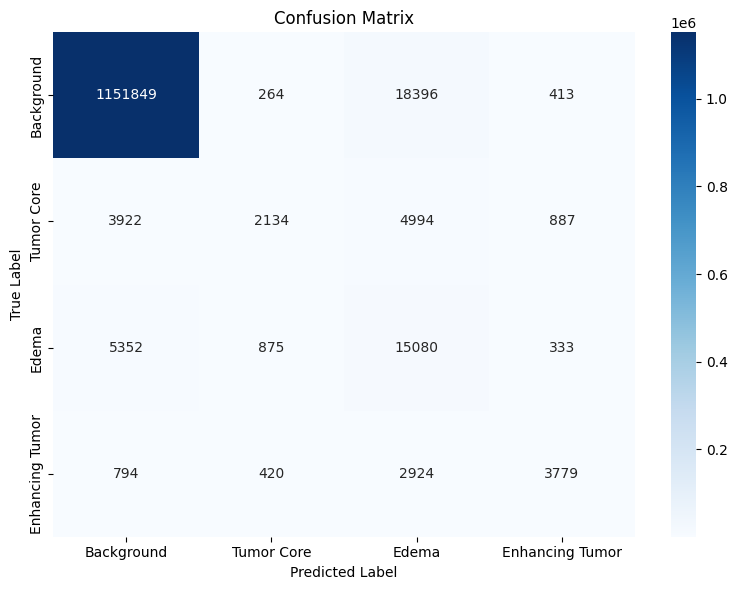

/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/torchio/data/image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


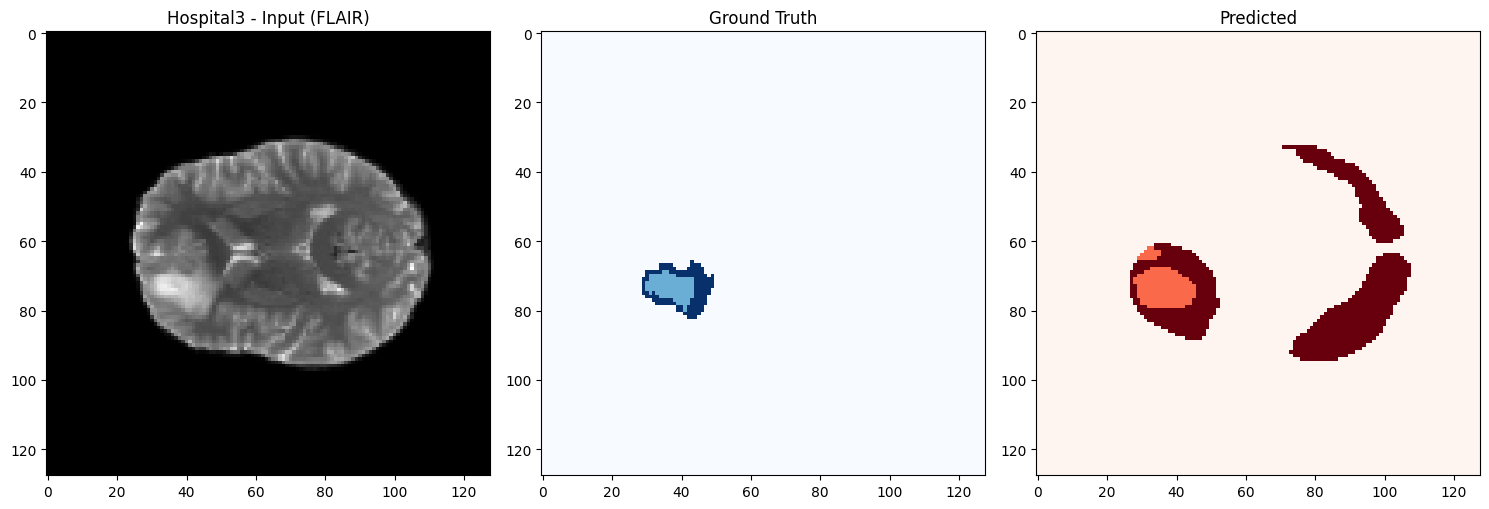

In [43]:
# Cell 9: Final Testing and Prediction Visualization
class_names = ["Background", "Tumor Core", "Edema", "Enhancing Tumor"]

def predict_and_overlay(model, loader, slice_idx=64, client_name="Client"):
    model.eval()
    image, label, _ = next(iter(loader))
    image = image.to(device)
    label = label.to(device)
    with torch.no_grad():
        output = model(image)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    true = label.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image[0, 3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{client_name} - Input (FLAIR)")

    axs[1].imshow(true[:, :, slice_idx], cmap='Blues')  # ✅ Fixed
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred[:, :, slice_idx], cmap='Reds')
    axs[2].set_title("Predicted")

    plt.tight_layout()
    plt.show()


def global_test(global_model, hospital_loaders, client_names):
    results = {}
    for client in client_names:
        val_loader = hospital_loaders[client]["val"]
        dice = evaluate_model(global_model.to(device), val_loader, device=device)
        results[client] = dice
        print(f"🏥 Final Dice on {client}: {dice:.4f}")
        predict_and_overlay(global_model, val_loader, client_name=client)
    return results


import numpy as np
from sklearn.metrics import confusion_matrix

def compute_metrics_for_eval(preds, labels, num_classes=4):
    """
    Compute confusion matrix, IoU, and Dice scores for multi-class predictions.
    
    Args:
        preds (Tensor): Predicted labels (N, D, H, W)
        labels (Tensor): Ground truth labels (N, D, H, W)
        num_classes (int): Number of segmentation classes

    Returns:
        dict: {
            "confusion_matrix": ndarray,
            "iou": list of floats,
            "dice": list of floats
        }
    """
    preds = preds.flatten()
    labels = labels.flatten()

    cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy(), labels=list(range(num_classes)))
    intersection = np.diag(cm)
    gt_total = cm.sum(axis=1)
    pred_total = cm.sum(axis=0)
    union = gt_total + pred_total - intersection

    iou = (intersection / (union + 1e-6)).tolist()
    dice = ((2 * intersection) / (gt_total + pred_total + 1e-6)).tolist()

    return {
        "confusion_matrix": cm,
        "iou": iou,
        "dice": dice
    }


# def predict_and_evaluate(model, loader, device="cuda", num_classes=4):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for batch in loader:
#             if len(batch) == 3:
#                 images, labels, _ = batch
#             else:
#                 images, labels = batch
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             preds = torch.argmax(outputs, dim=1)

#             all_preds.append(preds.cpu())
#             all_labels.append(labels.squeeze(1).cpu())

#     all_preds = torch.cat(all_preds, dim=0)
#     all_labels = torch.cat(all_labels, dim=0)

#     return compute_metrics_for_eval(all_preds, all_labels, num_classes=num_classes)


def predict_and_evaluate(model, loader, device="cuda", num_classes=4, slice_idx=64):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Only take a single axial slice
            pred_slice = preds[0, :, :, slice_idx].cpu().flatten()
            label_slice = labels[0, 0, :, :, slice_idx].cpu().flatten()

            all_preds.append(pred_slice)
            all_labels.append(label_slice)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return compute_metrics_for_eval(all_preds, all_labels, num_classes=num_classes)


import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, normalize=False, title="Confusion Matrix"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Show final metrics
metrics = predict_and_evaluate(global_model, hospital_loaders["Hospital3"]["val"])
print(metrics["dice"])
plot_confusion_matrix(metrics["confusion_matrix"], class_names)


# Visual inspection
predict_and_overlay(global_model, hospital_loaders["Hospital3"]["val"], client_name="Hospital3")





🔍 Evaluating Hospital3...


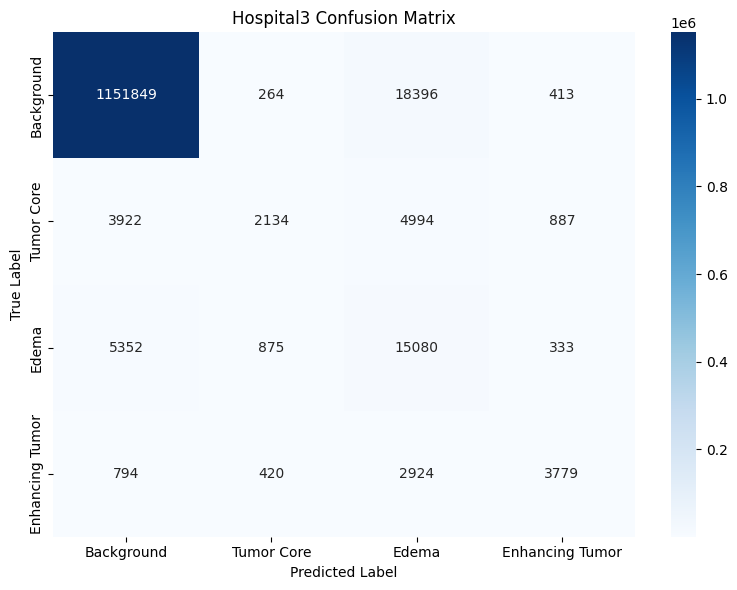

/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/torchio/data/image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


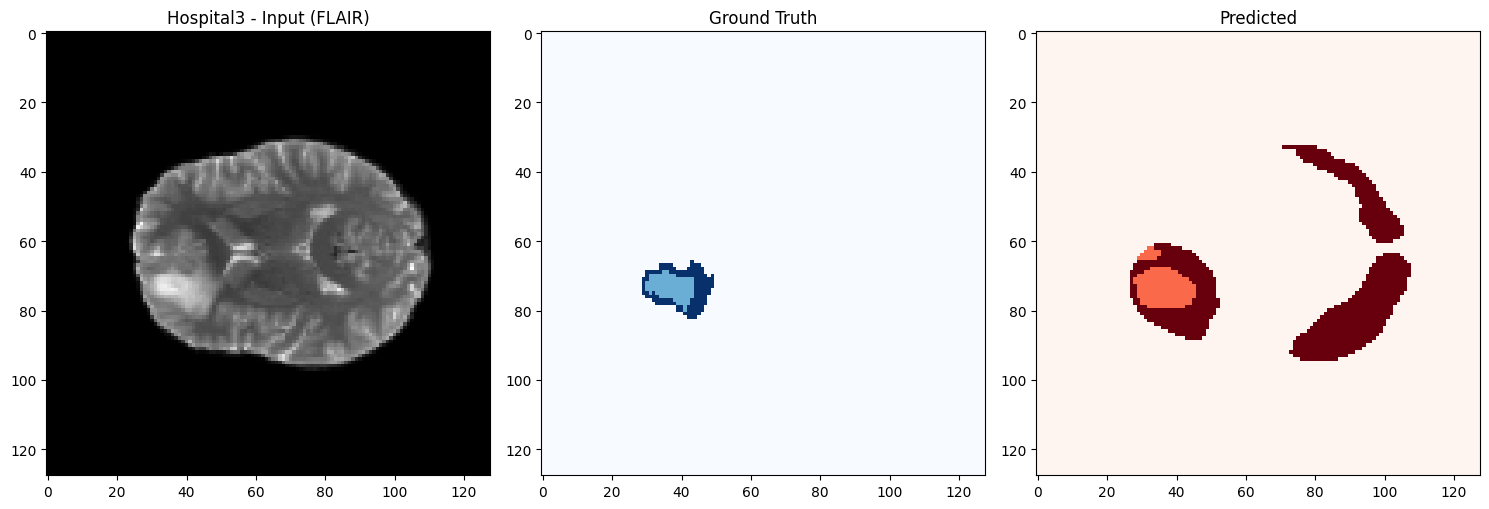


🔍 Evaluating Hospital4...


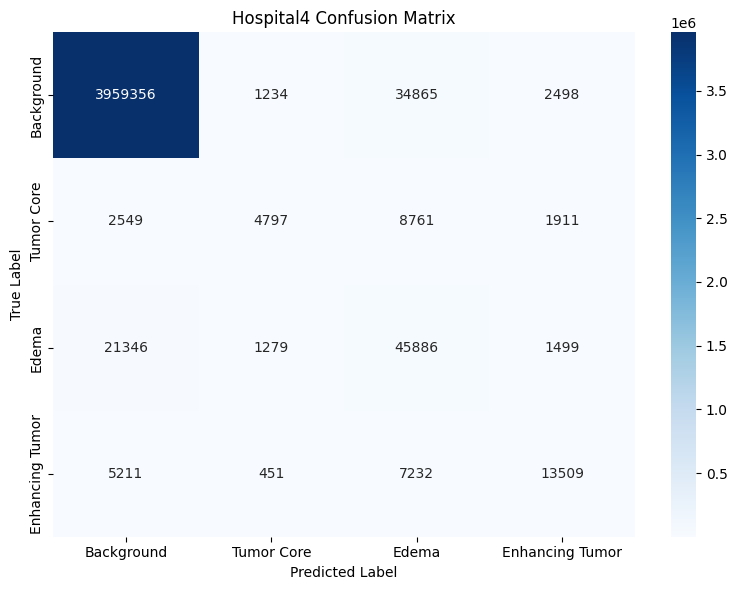

/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/torchio/data/image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


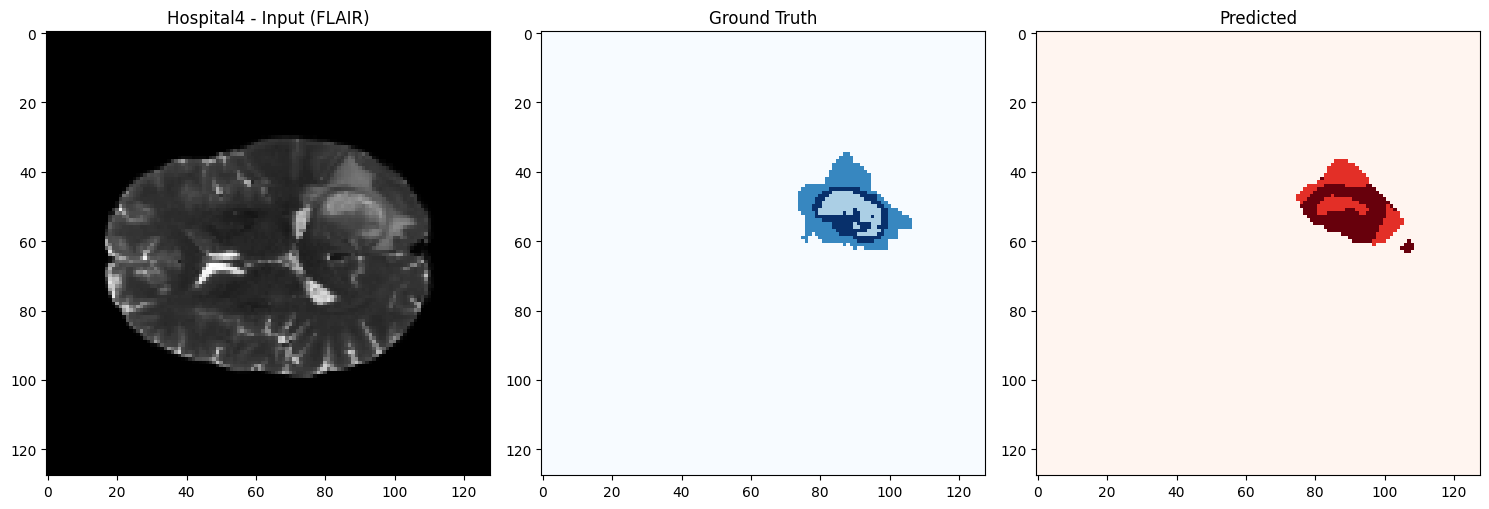

✅ Saved results to TwinSegNet_Metrics_PerClient.csv


,Client,Background_Dice,Background_IoU,Tumor Core_Dice,Tumor Core_IoU,Edema_Dice,Edema_IoU,Enhancing Tumor_Dice,Enhancing Tumor_IoU
0,Hospital3,0.987508,0.975325,0.273065,0.158121,0.478472,0.314468,0.567034,0.395707
1,Hospital4,0.991523,0.983188,0.372163,0.228625,0.550344,0.379637,0.589655,0.418093


In [44]:
def evaluate_all_clients(global_model, hospital_loaders, client_list, class_names, device="cuda", num_classes=4):
    results = []

    for client in client_list:
        print(f"\n🔍 Evaluating {client}...")
        loader = hospital_loaders[client]["val"]
        metrics = predict_and_evaluate(global_model, loader, device=device, num_classes=num_classes)

        row = {"Client": client}
        for i, cls in enumerate(class_names):
            row[f"{cls}_Dice"] = metrics["dice"][i]
            row[f"{cls}_IoU"] = metrics["iou"][i]

        results.append(row)

        plot_confusion_matrix(metrics["confusion_matrix"], class_names, normalize=False, title=f"{client} Confusion Matrix")
        predict_and_overlay(global_model, loader, client_name=client)

    results_df = pd.DataFrame(results)
    results_df.to_csv("TwinSegNet_Metrics_PerClient.csv", index=False)
    print("✅ Saved results to TwinSegNet_Metrics_PerClient.csv")
    return results_df

# Run across all clients
client_list = list(hospital_loaders.keys())
metrics_df = evaluate_all_clients(global_model, hospital_loaders, client_list, class_names)
metrics_df


In [39]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def plot_roc_curve(model, loader, class_names, device="cuda"):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                X, Y, _ = batch
            else:
                X, Y = batch
            X, Y = X.to(device), Y.to(device)

            # Model prediction: shape [B, C, D, H, W]
            Y_pred = model(X)

            # Softmax over classes
            probs = F.softmax(Y_pred, dim=1)  # [B, C, D, H, W]

            # Flatten predictions and labels
            probs = probs.permute(0, 2, 3, 4, 1).reshape(-1, probs.shape[1])  # [N, C]
            Y_flat = Y.view(-1)

            # One-hot encode ground truth
            y_true_1hot = F.one_hot(Y_flat, num_classes=probs.shape[1]).cpu().numpy()
            y_true.append(y_true_1hot)
            y_scores.append(probs.cpu().numpy())

    # Concatenate all batches
    y_true = np.concatenate(y_true, axis=0)
    y_scores = np.concatenate(y_scores, axis=0)

    # Plotting ROC curves
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Each Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/torchio/data/image.py:248: UserWarning: Using TorchIO images without a torchio.SubjectsLoader in PyTorch >= 2.3 might have unexpected consequences, e.g., the collated batches will be instances of torchio.Subject with 5D images. Replace your PyTorch DataLoader with a torchio.SubjectsLoader so that the collated batch becomes a dictionary, as expected. See https://github.com/TorchIO-project/torchio/issues/1179 for more context about this issue.
  warnings.warn(message, stacklevel=1)


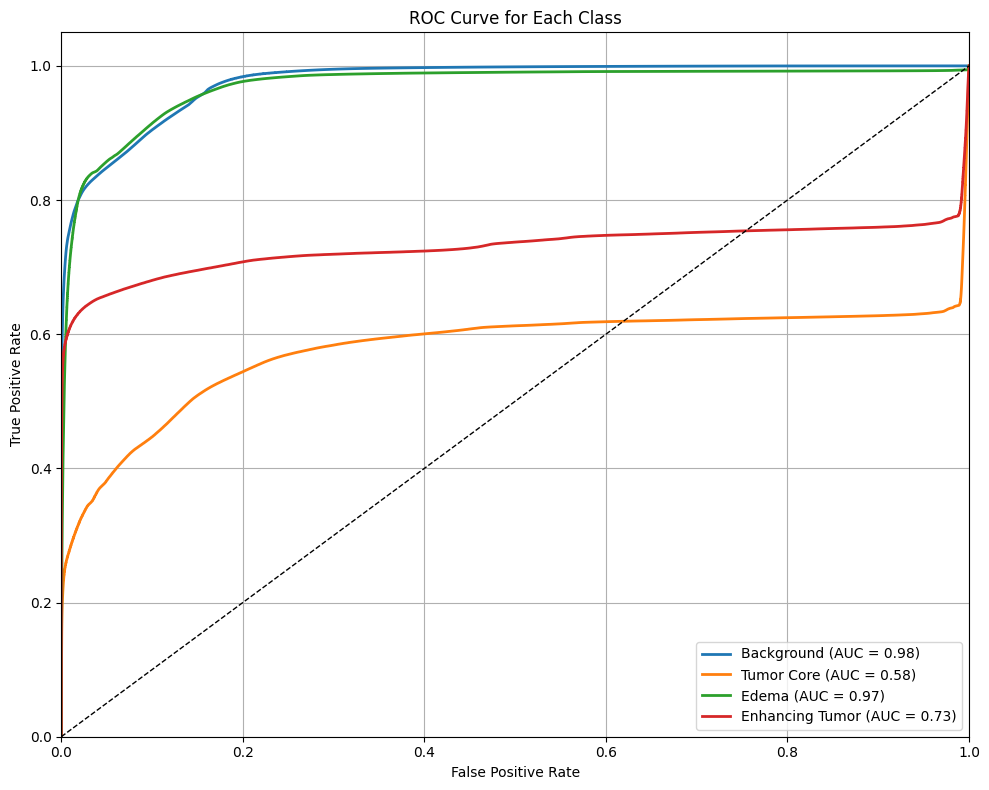

In [40]:
plot_roc_curve(global_model, hospital_loaders["Hospital3"]["val"], class_names)


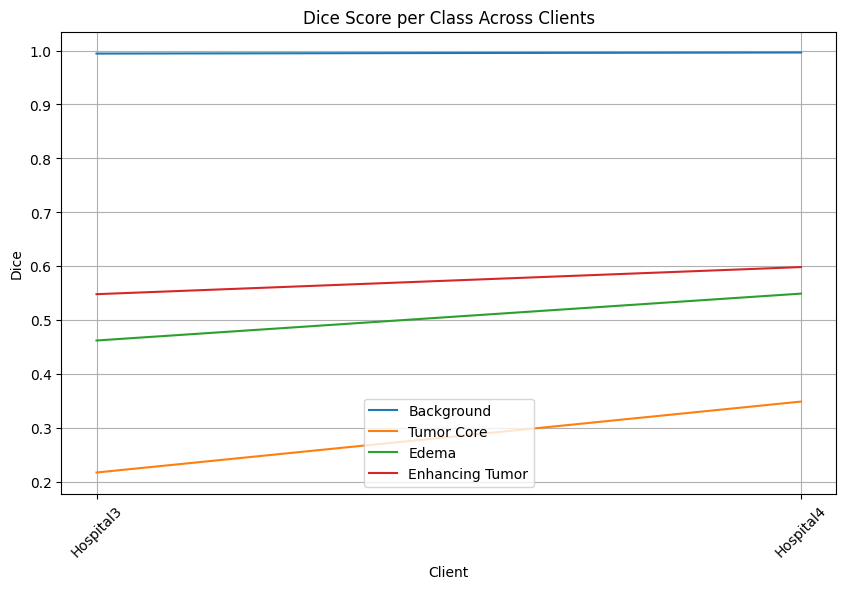

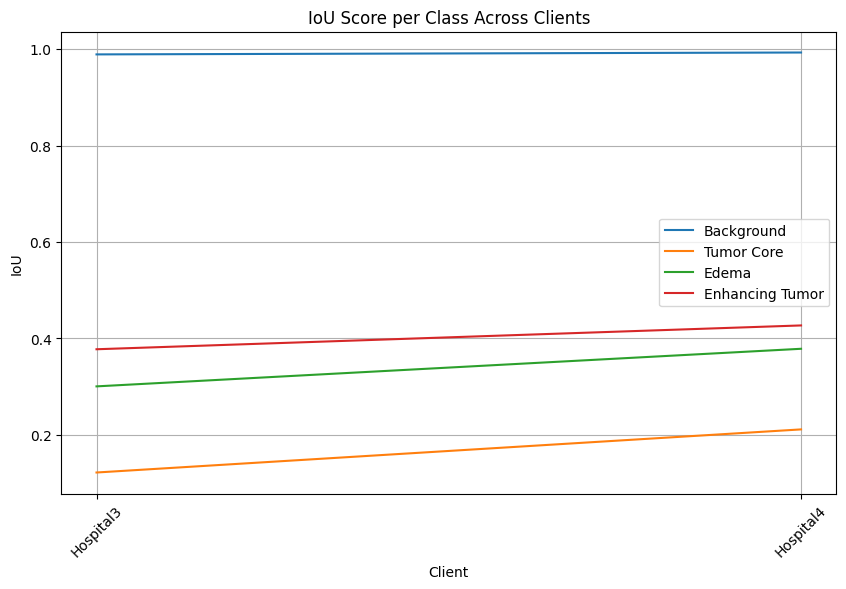

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load if not in memory
df = pd.read_csv("TwinSegNet_Metrics_PerClient.csv")

# Plot per-class Dice scores
def plot_metric(df, metric_type="Dice", save_path=None):
    class_names = ["Background", "Tumor Core", "Edema", "Enhancing Tumor"]
    plt.figure(figsize=(10, 6))
    
    for cls in class_names:
        col = f"{cls}_{metric_type}"
        sns.lineplot(data=df, x="Client", y=col, label=cls)
    
    plt.title(f"{metric_type} Score per Class Across Clients")
    plt.ylabel(metric_type)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_metric(df, "Dice", save_path="dice_comparison.png")
plot_metric(df, "IoU", save_path="iou_comparison.png")
